# Assignment 5 - MDR

## Submitted by:
- Qazi Umer Jamil
- NUST Regn No 317920
- RIME-19

## Assignment:
- Use ML/DL to differentiate between individual and combined finger movements. Use all classes. Bonus marks for DL architecture. Also bonus marks on achieving higher accuracy than claimed results.

- Use the following 2 links:
-- https://www.rami-khushaba.com/electromyogram-emg-repository.html (use data set 2)
-- https://archive.ics.uci.edu/ml/datasets/EMG+Physical+Action+Data+Set (for reference)


# Intro to the Dataset

A description of the database is as follows:

- No of subjects: 8 (6M, 2F)
- No of channels: 8
- No of classes: 15: 
- 1. Thumb (T)
- 2. Index (I)
- 3. Middle (M)
- 4. Ring (R)
- 5. Little (L) 
- 6. the combined Thumb-Index (T-I)
- 7. Thumb-Middle (T-M)
- 8. Thumb-Ring (T-R)
- 9. Thumb-Little (TL)
- 10. Index-Middle (I-M)
- 11. Middle-Ring (M-R)
- 12. Ring-Little (RL)
- 13. Index-Middle-Ring (I-M-R)
- 14. Middle-Ring-Little (M-RL)
- 15. hand close class (HC)


- Sampling freq: 4000 Hz

Refrence: 

- R. N. Khushaba and Sarath Kodagoda, “Electromyogram (EMG) Feature Reduction Using Mutual Components Analysis for Multifunction Prosthetic Fingers Control”‏, in Proc. Int. Conf. on Control, Automation, Robotics & Vision (ICARCV), Guangzhou, 2012, pp. 1534-1539. (6 pages)


To reduce the project report size, I have ommitted some redundant code sections. Full code is available at https://colab.research.google.com/drive/1jAESGVvglauuV3OtwHsBPfLik04HuxJe?usp=sharing

## Loading the dataset

The dataset was uploaded on Google Drive and was processed in Google Colab for faster and GPU enabled computations. 

First, we will get access from the google drive

In [2]:
#Mounting the google drive so that the dataset uploaded on it can be accessed in Colab

from google.colab import drive

drive.mount("/content/gdrive")

!ls "/content/gdrive/My Drive/S1-EMG_Dataset"

Mounted at /content/gdrive
HC_1.csv  I_M1.csv  L_L1.csv  M_R1.csv	R_L1.csv  T_I1.csv  T_M1.csv  T_T1.csv
I_I1.csv  IMR1.csv  M_M1.csv  MRL1.csv	R_R1.csv  T_L1.csv  T_R1.csv


To load the dataset in X, y (supervised learning format), I have defined the following function.

In [3]:
# To load the data in X, y (Supervised Learning fromat)

def load_data(entry):
    X = pd.read_csv(base_path+entry, header=None,)
    label_array = [entry.split(".")[0] for x in range(np.shape(X)[0])]
    y = pd.DataFrame(label_array, columns = None)

    print("Data loading from", entry, "file is successfull")
    return X, y 

The actual dataset contains 360 files with total size of 3.36 GB. I try to run but unfortuantely it required 70+ hours of training/feature extraction part. Therefore, I just used the data of one subject only and still it took 3+ hours for training/feature extraction part. 

In [4]:
# Loadind data from the directories
base_path = "/content/gdrive/My Drive/S1-EMG_Dataset/"

entries = os.listdir(base_path)

X = []
y = []

for entry in entries:
    if "Store" not in entry:
        print(entry)
        data, label = load_data(entry)
        X.append(data)
        y.append(label)


I_M1.csv
Data loading from I_M1.csv file is successfull
M_R1.csv
Data loading from M_R1.csv file is successfull
R_L1.csv
Data loading from R_L1.csv file is successfull
IMR1.csv
Data loading from IMR1.csv file is successfull
MRL1.csv
Data loading from MRL1.csv file is successfull
T_I1.csv
Data loading from T_I1.csv file is successfull
T_M1.csv
Data loading from T_M1.csv file is successfull
T_R1.csv
Data loading from T_R1.csv file is successfull
T_L1.csv
Data loading from T_L1.csv file is successfull
HC_1.csv
Data loading from HC_1.csv file is successfull
T_T1.csv
Data loading from T_T1.csv file is successfull
I_I1.csv
Data loading from I_I1.csv file is successfull
M_M1.csv
Data loading from M_M1.csv file is successfull
R_R1.csv
Data loading from R_R1.csv file is successfull
L_L1.csv
Data loading from L_L1.csv file is successfull


The dataset is loaded in Pandas dataframe format. To ease processing, I will combine the X, y dataframes into one as follows:

In [5]:
X_data = pd.concat(X, axis=0, ignore_index=True)
y_data = pd.concat(y, axis=0, ignore_index=True)

X_data.columns=["channel_1", "channel_2", "channel_3", "channel_4", "channel_5", "channel_6", "channel_7", "channel_8"]
y_data.columns = ["label"]

data = pd.concat([X_data, y_data], axis=1)


## Data Visualization

### Plotting raw EMG signals
To plot the data for one subject and for all 8 channel, I have defined the function as follows. 

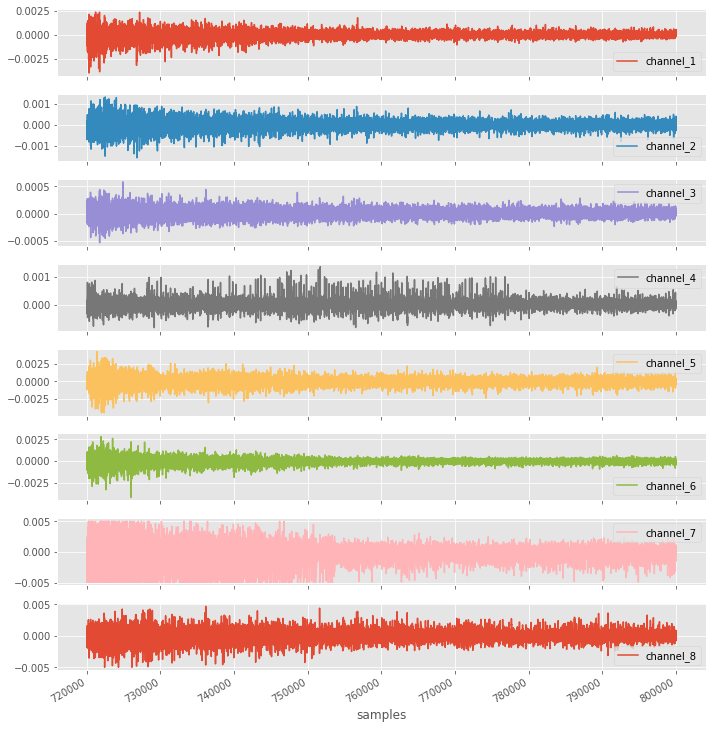

In [6]:
# Select only on subject using if else
sub1_data = data.loc[data['label']=="HC_1"].copy() 

def plot_all_channels(data, idx_start, idx_end):
    data.iloc[idx_start:idx_end, :].plot(subplots=True, figsize=(10,10))
    plt.tight_layout()
    plt.xlabel('samples')
    plt.show()
    
plot_all_channels(sub1_data, 0, len(sub1_data))

### Classes distribution

The number of instances of each class is as follows:

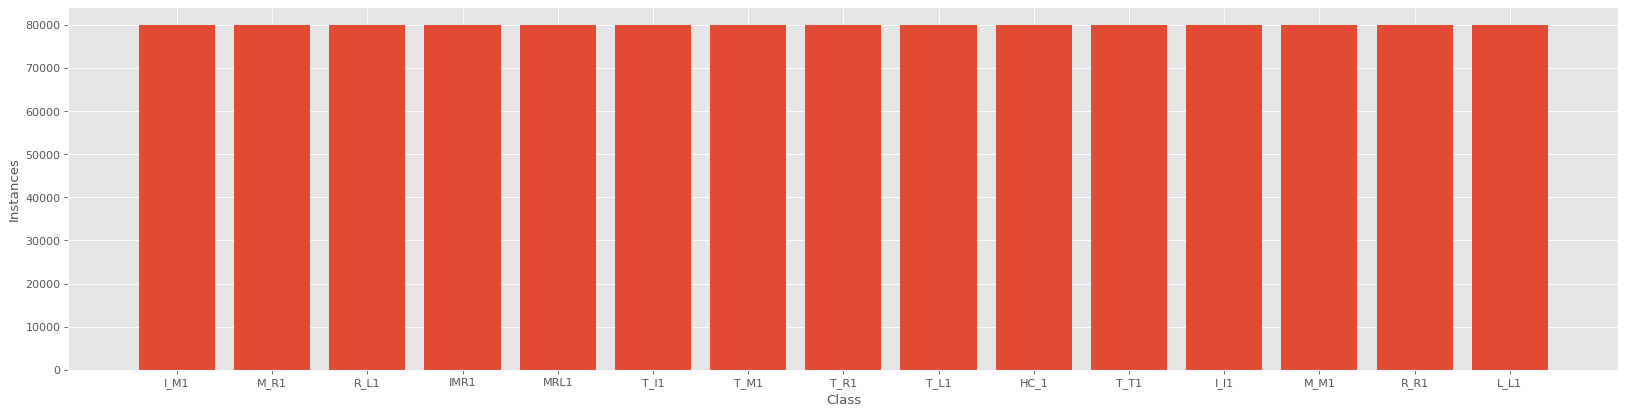

In [7]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
def plot_class_instances(y):
    targets = y.unique()
    instances = y.value_counts().to_list()
    plt.bar(targets, instances)
    plt.xlabel('Class')
    plt.ylabel('Instances')
    plt.show()
    
# plot class instances with data labelled 0 removed
plot_class_instances(data["label"])

# Signal Processing
Here, I will do the simple signal processing to remove noise.

## Bandpass and Bandstop filters
- Usually, raw EMG signals are filtered between 20 Hz - 450 Hz. Below this range are movement artefacts, and above is undesired high frequency noise. A bandpass filter will be used to obtain frequencies in this range. 
- The signals are also filtered at 50 Hz with a bandstop filter to remove mains interference.


The bandpass and the bandstop filters are defined below:

In [8]:
SAMPLING_FREQ = 4000
FILTER_ORDER = 4

def get_filter(filter_type, cutoff):
    nyquist_freq = SAMPLING_FREQ/2 # Hz
    cutoff_freqs_frac = [x/nyquist_freq for x in cutoff] # cutoff frequency given as fraction of Nyquist frequency
    b, a = signal.butter(FILTER_ORDER, cutoff_freqs_frac, btype=filter_type) # note analog = False
    return b, a
    
cutoff_freqs = [20, 450] # Hz
b_bandpass, a_bandpass = get_filter('bandpass', cutoff_freqs)

cutoff_freqs = [45, 55]
b_bandstop, a_bandstop = get_filter('bandstop', cutoff_freqs)

Now, it is time to apply the above function to our dataset as follows

In [9]:
data_np = data.iloc[:,0:8].to_numpy() # convert the pandas dataframe to numpy array
filtered_data_1 = signal.filtfilt(b_bandpass, a_bandpass, data_np, padlen=0, axis=0) # high pass filtering
filtered_data_2 = signal.filtfilt(b_bandstop, a_bandstop, filtered_data_1, padlen=0, axis=0) # notch filter
new_data = pd.DataFrame(data=filtered_data_2) # convert numpy array to pandas dataframe
new_data.columns=["channel_1", "channel_2", "channel_3", "channel_4", "channel_5", "channel_6", "channel_7", "channel_8"]
new_data['label'] = data['label'].copy()

In [10]:
new_data.head()

,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,label
0,0.000272,0.000038,0.000021,0.000083,3.284477e-05,-0.000064,0.000028,0.000119,I_M1
1,0.000326,0.000056,0.000014,0.000085,3.201195e-05,-0.000058,0.000034,0.000119,I_M1
2,0.000339,0.000068,0.000002,0.000086,2.577998e-05,-0.000056,0.000036,0.000099,I_M1
3,0.000292,0.000069,-0.000015,0.000085,1.435863e-05,-0.000059,0.000032,0.000054,I_M1
4,0.000179,0.000058,-0.000034,0.000083,-3.435105e-07,-0.000063,0.000023,-0.000010,I_M1


# Features Extraction

Raw EMG signals are very large in size and contain noise, therefore they cannot be fed to a training classifier directly. To address this, we can find the features of the signal that captures the important info of the signal. 

Sliding window method is used to extract the features. The sliding window operation has two hyper parameters:
1. Window length: number of samples in data
2. Overlap: number of samples the next window overlaps the previous one

Furthermore, signal's features can be of time domain and of frequency domain. In this work, features from both domain are calcualted. These features are as follows: 

Time domain:
1. Mean absolute value
2. Root mean square
3. Variance
4. Zero crossings - the number of times the signal crosses zero on the y axis
 
Frequency domain:
1. Peak frequency: frequency of the peak with greatest power
2. Peak power: greatest power in PSD
 
For each of these features (besides variance), a custom function has been defined.

Root mean square

In [12]:
def RMS(x):
    x_squared = x**2
    x_squared_mean = x_squared.mean()
    x_rms = np.sqrt(x_squared_mean)
    return x_rms

Zero crossing

In [13]:
def ZC(x):
    zc = ((np.array(x)[:-1] * np.array(x)[1:]) < 0).sum()
    return zc

Mean absolute value function

In [11]:
def MAV(x):
    x_abs = x.abs() 
    x_mav = x_abs.mean()
    return x_mav

Peak power

In [14]:
def PP(x):
    freqs, psd = signal.welch(x)
    peak_power = np.max(psd)
    return peak_power

Peak frequency

In [15]:
def PF(x):
    freqs, psd = signal.welch(x)
    peak_power_idx = np.argmax(psd)
    peak_freq = freqs[peak_power_idx]
    return peak_freq

Feature extraction is performed with the feature_extraction function below. The pandas rolling function is a sliding window of step size 1 (no argument for overlap). Thus, for each 500 sample window the features are extracted, and then downsampled with [::overlap] to get the correct overlap. 

In [16]:
# Defining sliding window parameters
WINDOW_LENGTH = 8000
OVERLAP = 3000 # sample every 8000th window to get 3000 sample overlap

def feature_extraction(data):
    
    targets = data['label'].unique() # list of integers of the different classes
    feature_spaces = [] # list to append the feature space of each different class into

    for target in targets: # i.e. for each hand gesture
        print("Doing calculations for", target)
        # get data of the correct class
        target_data = data.loc[data['label']==target].copy() 
        target_data.reset_index(drop=True, inplace=True)
        
        # drop target column, not needed now
        target_data.drop('label', axis=1, inplace=True)
                        
        # mean absolute value
        target_data_mav = target_data.rolling(window=WINDOW_LENGTH).agg(MAV)[::OVERLAP] 
        # agg axis=0 (default) applies function to each column
        target_data_mav = target_data_mav.add_suffix('_mav') # adjust column names accordingly
        print("calculating mav")

        # variance
        target_data_var = target_data.rolling(window=WINDOW_LENGTH).var()[::OVERLAP]
        target_data_var = target_data_var.add_suffix('_var')
        print("calculating var")

        # zero crossings
        target_data_zc = target_data.rolling(window=WINDOW_LENGTH).agg(ZC)[::OVERLAP]
        target_data_zc = target_data_zc.add_suffix('_zc')
        print("calculating zc")
        
        # peak frequency
        target_data_pf = target_data.rolling(window=WINDOW_LENGTH).agg(PF)[::OVERLAP]
        target_data_pf = target_data_pf.add_suffix('_pf')
        print("calculating pf")
        
        # peak power
        target_data_pp = target_data.rolling(window=WINDOW_LENGTH).agg(PP)[::OVERLAP]
        target_data_pp = target_data_pp.add_suffix('_pp')
        print("calculating pp")
        
        # feature space for each class created
        target_feature_space = pd.concat([target_data_mav, target_data_var, target_data_zc, 
                                          target_data_pf, target_data_pp], axis=1)
        target_feature_space.dropna(inplace=True) # Nans at the beginning
        
        # create target vector of correct length 
        target_feature_space['label'] = [target]*len(target_feature_space)
        
        # append current class feature space to list of feature spaces
        feature_spaces.append(target_feature_space)

    print("for loop exited")
    feature_space = pd.concat(feature_spaces)
    feature_space.reset_index(drop=True, inplace=True)

    x = feature_space.iloc[:, 0:-1]
    y = feature_space['label']
    
    return x, y


In [17]:
# Extracting features
x, y = feature_extraction(new_data)

Doing calculations for I_M1
calculating mav
calculating var
calculating zc
calculating pf
calculating pp
Doing calculations for M_R1
calculating mav
calculating var
calculating zc
calculating pf
calculating pp
Doing calculations for R_L1
calculating mav
calculating var
calculating zc
calculating pf
calculating pp
Doing calculations for IMR1
calculating mav
calculating var
calculating zc
calculating pf
calculating pp
Doing calculations for MRL1
calculating mav
calculating var
calculating zc
calculating pf
calculating pp
Doing calculations for T_I1
calculating mav
calculating var
calculating zc
calculating pf
calculating pp
Doing calculations for T_M1
calculating mav
calculating var
calculating zc
calculating pf
calculating pp
Doing calculations for T_R1
calculating mav
calculating var
calculating zc
calculating pf
calculating pp
Doing calculations for T_L1
calculating mav
calculating var
calculating zc
calculating pf
calculating pp
Doing calculations for HC_1
calculating mav
calculating

# Standardization 

In [19]:
scaler = preprocessing.StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)

# Dimensionality Reduction
The resulting feature space is 40-dimensional. To aid training, this dimensionality should be reduced. For this, principal component analysis will be used. 

Cumulative explained variance by components (%)
 1 components: 38.67
 2 components: 50.60
 3 components: 60.27
 4 components: 68.42
 5 components: 72.73
 6 components: 76.23
 7 components: 79.39
 8 components: 82.13
 9 components: 84.56
 10 components: 86.84
 11 components: 88.73
 12 components: 90.43
 13 components: 91.97
 14 components: 93.40
 15 components: 94.55
 16 components: 95.56
 17 components: 96.55
 18 components: 97.28
 19 components: 97.89
 20 components: 98.36
 21 components: 98.79
 22 components: 99.09
 23 components: 99.32
 24 components: 99.53
 25 components: 99.66
 26 components: 99.73
 27 components: 99.79
 28 components: 99.83
 29 components: 99.86
 30 components: 99.89


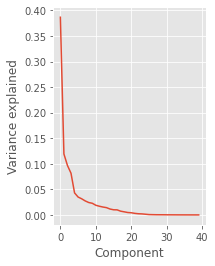

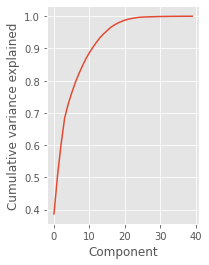

In [20]:
pca = PCA()
pca.fit(x_scaled) # fit pca on the feature space to get the principal components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
cumulative_explained_variance_percent = list(np.round(cumulative_explained_variance_ratio*100,2))
print('Cumulative explained variance by components (%)')
for i in range(1,31):
    print(' %d components: %.2f' % (i, cumulative_explained_variance_percent[i-1]))

# plot of explained variance 
plt.subplot(1, 2, 1)
plt.plot(explained_variance_ratio)
plt.ylabel('Variance explained')
plt.xlabel('Component')
plt.show()

# plot of cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(cumulative_explained_variance_ratio)
plt.ylabel('Cumulative variance explained')
plt.xlabel('Component')
plt.show()

Moving forward, the feature space is reduced down to 20, halfing the dimensionality whilst retaining 93% of the explained variance in the feature space. 

In [21]:
x_transformed = pca.transform(x)

num_dimensions = 20
xt = x_transformed[:, 0:num_dimensions]

## Dataset splitting

In [22]:
# For data splitting and shuffling

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)
    print("Data splited into train and test sets\n")
    return X_train, X_test, y_train, y_test

In [23]:
X_train, X_test, y_train, y_test = split_data(xt, y)

Data splited into train and test sets



In above loaded the data for each class, and also split it into training and testing sets as well. 

Next, we will stack/combine out data for all of the classes in (X, y) form for our supervised learning models. 

In [24]:
# Number of classes:

K = len(set(y_train))
print("Total number of classes present in the dataset: ", K)

Total number of classes present in the dataset:  15


In [25]:
print("Size of y_train",  np.shape(y_train))
print("Size of y_test",  np.shape(y_test))

Size of y_train (270,)
Size of y_test (90,)


In [26]:
#Shuffling the datasets

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)    

# Model 01: Linear discriminant analysis (LDA)

LDA is used to find a linear combination of features that characterizes or separates two or more classes of objects or events.

Lets define the model now.

In [27]:
# Defining the LDA model
model_LDA = LinearDiscriminantAnalysis()

# defining the model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluating model
scores_training_LDA = cross_val_score(model_LDA, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)

# fit model
model_LDA.fit(X_train, y_train)

# make a prediction
yhat = model_LDA.predict(X_test)
scores_testing_LDA = accuracy_score(y_test, yhat)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


## LDA Model Accuracy

In [28]:
# Printing the training and testing accuracy

print('Mean Training Accuracy: %.3f' % (mean(scores_training_LDA)*100))
print('Mean Testing Accuracy: %.3f' % (mean(scores_testing_LDA)*100))

Mean Training Accuracy: 98.148
Mean Testing Accuracy: 95.556


# Model 02: Support Vector Machine

SVM can also be used to find features for classfication

Lets define the model now.

In [29]:
# Defining the SVM model
model_SVC = SVC(kernel='poly', degree=3, C = 1)

# defining the model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluating model
scores_training_SVM = cross_val_score(model_SVC, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)

# fit model
model_SVC.fit(X_train, y_train)

# make a prediction
yhat = model_SVC.predict(X_test)
scores_testing_SVM = accuracy_score(y_test, yhat)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


## SVM Model Accuracy

In [30]:
# Printing the training and testing accuracy

print('Mean Training Accuracy: %.3f' % (mean(scores_training_SVM)*100))
print('Mean Testing Accuracy: %.3f' % (mean(scores_testing_SVM)*100))

Mean Training Accuracy: 39.506
Mean Testing Accuracy: 30.000


# Model 3: Convolutional Neural Network (CNN)

Here, we will use Convolutional Neural Network (CNN) for classification.

First we have to reshape our input in following form: 

- [batch_size, no_of_timestamps, no_of_channels]

Tensorflow can already infer batch size. No of time stamps in our case is 3600 and no of channel is 1. So our input shape will be [batch_size, 3600, 1]. We will also one hot encode our label vectors. This can be implemented as follows:

In [31]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

print("Size of Previous X_train",  np.shape(X_train))
print("Size of Previous X_test",  np.shape(X_test))

print("\n")

X_train_n = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1]).astype(np.float64)
X_test_n = np.reshape(X_test, [X_test.shape[0], X_test.shape[1], 1]).astype(np.float64)

code1 = np.array(y_train)
label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(code1)
y_train_n = tf.keras.utils.to_categorical(vec, num_classes=K)

code1 = np.array(y_test)
label_encoder2 = LabelEncoder()
vec2 = label_encoder.fit_transform(code1)
y_test_n = tf.keras.utils.to_categorical(vec2, num_classes=K)

print("Size of New X_train",  np.shape(X_train_n))
print("Size of New X_test",  np.shape(X_test_n))

print("\n")

print("Size of y_train",  np.shape(y_train_n))
print("Size of y_test",  np.shape(y_test_n))

Size of Previous X_train (270, 20)
Size of Previous X_test (90, 20)


Size of New X_train (270, 20, 1)
Size of New X_test (90, 20, 1)


Size of y_train (270, 15)
Size of y_test (90, 15)


Now, we will define  our CNN model architecture. 

In [32]:
verbose, epochs, batch_size = 1, 15, 32

n_timesteps, n_channels, n_outputs = X_train_n.shape[1], X_train_n.shape[2], y_train_n.shape[1]

def CNN_model_arch(n_timesteps, n_channels, n_outputs):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_channels)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    return model

CNN_model = CNN_model_arch(n_timesteps, n_channels, n_outputs)
CNN_model.summary()
CNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 128)           512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            24640     
_________________________________________________________________
dropout (Dropout)            (None, 16, 64)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               6

Lets train our model now

In [33]:
history = CNN_model.fit(X_train_n, y_train_n, epochs=epochs, validation_data=(X_test_n, y_test_n), batch_size=batch_size, verbose=verbose)

# Save model weights
CNN_model.save_weights("CNN_model_weights.hdf5") 

Epoch 1/15
9/9 [==============================] - 8s 61ms/step - loss: 3.3346 - accuracy: 0.0594 - val_loss: 4.5554 - val_accuracy: 0.0778
Epoch 2/15
9/9 [==============================] - 0s 7ms/step - loss: 2.8719 - accuracy: 0.1028 - val_loss: 3.8035 - val_accuracy: 0.1778
Epoch 3/15
9/9 [==============================] - 0s 7ms/step - loss: 2.5920 - accuracy: 0.1781 - val_loss: 3.0182 - val_accuracy: 0.1222
Epoch 4/15
9/9 [==============================] - 0s 7ms/step - loss: 2.4255 - accuracy: 0.1876 - val_loss: 2.6379 - val_accuracy: 0.1111
Epoch 5/15
9/9 [==============================] - 0s 7ms/step - loss: 2.3208 - accuracy: 0.2426 - val_loss: 2.4462 - val_accuracy: 0.2556
Epoch 6/15
9/9 [==============================] - 0s 7ms/step - loss: 2.0035 - accuracy: 0.3251 - val_loss: 2.1929 - val_accuracy: 0.1667
Epoch 7/15
9/9 [==============================] - 0s 7ms/step - loss: 1.8203 - accuracy: 0.3581 - val_loss: 1.9852 - val_accuracy: 0.2444
Epoch 8/15
9/9 [=================

Lets evaluate the trained model

In [34]:
# Evaluating model
scores_training_CNN = CNN_model.evaluate(X_train_n, y_train_n, verbose=0)
scores_testing_CNN = CNN_model.evaluate(X_test_n, y_test_n, verbose=0)

print('Mean Training Accuracy: %.3f' % (mean(scores_training_CNN[1])*100))
print('Mean Testing Accuracy: %.3f' % (mean(scores_testing_CNN[1])*100))

Mean Training Accuracy: 65.556
Mean Testing Accuracy: 58.889


Now, lets plot the model training and validation accuracy plots

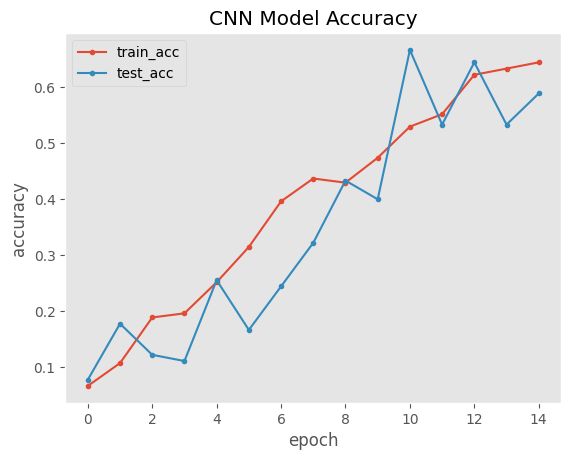

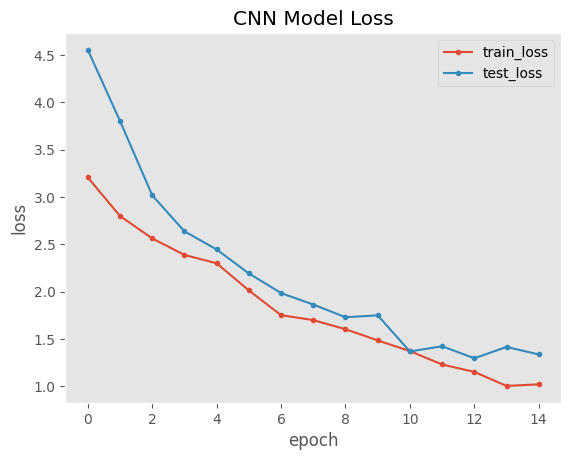

In [35]:
import matplotlib.style
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('ggplot')

# Plotting model accuracy
plt.plot(history.history['accuracy'], marker='.', label='train_acc')
plt.plot(history.history['val_accuracy'], marker='.', label='test_acc')
plt.title('CNN Model Accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# Plotting model validation accuracy
plt.plot(history.history['loss'], marker='.', label='train_loss')
plt.plot(history.history['val_loss'], marker='.', label='test_loss')
plt.title('CNN Model Loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')

plt.show()

# Model 4: Long short-term memory cells (LSTMs)

Here, we will use LSTM for classification.

The data is already shaped into our desired format (as it was done for CNN model previously).

Now, we will define our LSTM model architecture. 

In [36]:
verbose, epochs, batch_size = 1, 15, 32

n_timesteps, n_channels, n_outputs = X_train_n.shape[1], X_train_n.shape[2], y_train_n.shape[1]

def LSTM_model_arch(n_timesteps, n_channels, n_outputs):
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_channels)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    return model

LSTM_model = LSTM_model_arch(n_timesteps, n_channels, n_outputs)
LSTM_model.summary()
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 120)               12120     
_________________________________________________________________
dense_3 (Dense)              (None, 15)                1815      
Total params: 55,135
Trainable params: 54,935
Non-trainable params: 200
_________________________________________________________________


Lets train our model now

In [37]:
history = LSTM_model.fit(X_train_n, y_train_n, epochs=epochs, validation_data=(X_test_n, y_test_n), batch_size=batch_size, verbose=verbose)

# Save model weights
LSTM_model.save_weights("LSTM_model_weights.hdf5") 

Epoch 1/15
9/9 [==============================] - 2s 54ms/step - loss: 2.9383 - accuracy: 0.0957 - val_loss: 2.7294 - val_accuracy: 0.0889
Epoch 2/15
9/9 [==============================] - 0s 8ms/step - loss: 2.6451 - accuracy: 0.1519 - val_loss: 2.6937 - val_accuracy: 0.1444
Epoch 3/15
9/9 [==============================] - 0s 8ms/step - loss: 2.5149 - accuracy: 0.1514 - val_loss: 2.6578 - val_accuracy: 0.1667
Epoch 4/15
9/9 [==============================] - 0s 8ms/step - loss: 2.3516 - accuracy: 0.1882 - val_loss: 2.6225 - val_accuracy: 0.1667
Epoch 5/15
9/9 [==============================] - 0s 8ms/step - loss: 2.3759 - accuracy: 0.2084 - val_loss: 2.5848 - val_accuracy: 0.1556
Epoch 6/15
9/9 [==============================] - 0s 8ms/step - loss: 2.2099 - accuracy: 0.2381 - val_loss: 2.5459 - val_accuracy: 0.2000
Epoch 7/15
9/9 [==============================] - 0s 8ms/step - loss: 2.1400 - accuracy: 0.2539 - val_loss: 2.4810 - val_accuracy: 0.2000
Epoch 8/15
9/9 [=================

Lets evaluate the trained model

In [38]:
# Evaluating model
scores_training_LSTM = LSTM_model.evaluate(X_train_n, y_train_n, verbose=0)
scores_testing_LSTM = LSTM_model.evaluate(X_test_n, y_test_n, verbose=0)

print('Mean Training Accuracy: %.3f' % (mean(scores_training_LSTM[1])*100))
print('Mean Testing Accuracy: %.3f' % (mean(scores_testing_LSTM[1])*100))

Mean Training Accuracy: 46.296
Mean Testing Accuracy: 48.889


Now, lets plot the model training and validation accuracy plots

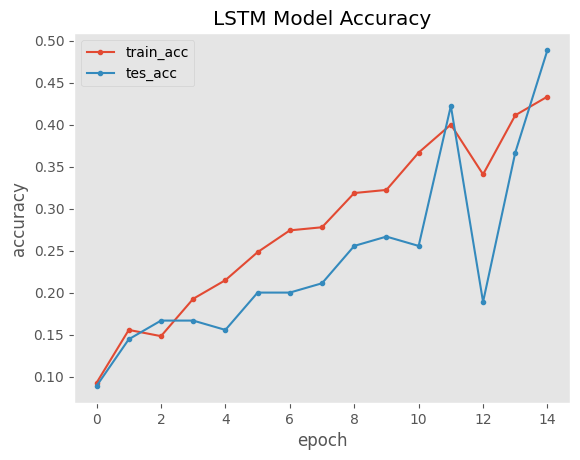

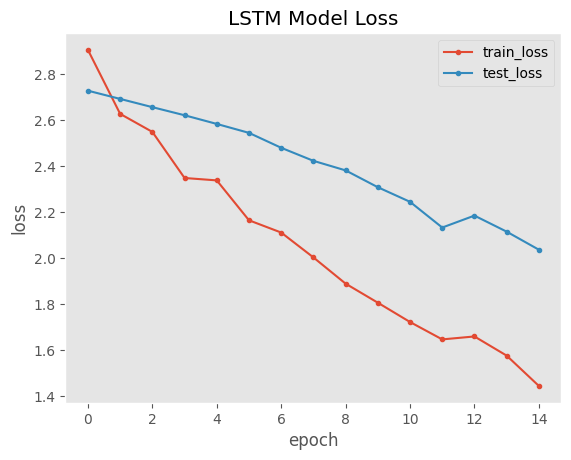

In [39]:
# Plotting model accuracy
plt.plot(history.history['accuracy'], marker='.', label='train_acc')
plt.plot(history.history['val_accuracy'], marker='.', label='tes_acc')
plt.title('LSTM Model Accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# Plotting model validation accuracy
plt.plot(history.history['loss'], marker='.', label='train_loss')
plt.plot(history.history['val_loss'], marker='.', label='test_loss')
plt.title('LSTM Model Loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')

plt.show()

# Conclusion and Summarized Results

In total, 4 supervised machine learning/deep learning models were trained and tested (LDA, SVM, CNN, LSTM). Genreally, the training accuracies were high on LDA, CNN and low on SVM, LSTM. I believe the deep learning models further has to be hyper tuned for achieving high accuracies on this dataset. Also, data from all the subjects can be used to improve the performance. Sliding window paramters can be adjusted to further tune the feature engineering part. 

The results/accuracies are as follows:

In [40]:
print("Summarized Results:\n")

print("1. LDA:")
print('Mean Training Accuracy: %.3f' % (mean(scores_training_LDA)*100))
print('Mean Testing Accuracy: %.3f' % (mean(scores_testing_LDA)*100))

print("\n")
print("2. SVM:")
print('Mean Training Accuracy: %.3f' % (mean(scores_training_SVM)*100))
print('Mean Testing Accuracy: %.3f' % (mean(scores_testing_SVM)*100))

print("\n")
print("3. CNN:")
print('Mean Training Accuracy: %.3f' % (mean(scores_training_CNN[1])*100))
print('Mean Testing Accuracy: %.3f' % (mean(scores_testing_CNN[1])*100))

print("\n")
print("4. LSTM:")
print('Mean Training Accuracy: %.3f' % (mean(scores_training_LSTM[1])*100))
print('Mean Testing Accuracy: %.3f' % (mean(scores_testing_LSTM[1])*100))

Summarized Results:

1. LDA:
Mean Training Accuracy: 98.148
Mean Testing Accuracy: 95.556


2. SVM:
Mean Training Accuracy: 39.506
Mean Testing Accuracy: 30.000


3. CNN:
Mean Training Accuracy: 65.556
Mean Testing Accuracy: 58.889


4. LSTM:
Mean Training Accuracy: 46.296
Mean Testing Accuracy: 48.889
